# C. Data Augmentation :
The U-net was shown in [7] to work well with only a limited number of training examples, provided one made heavy use of data augmentation. Accordingly, in order to maintain a reasonable amount of images, and above all to avoid overfitting by ensuring a sufficient invariance and robustness of the network, we followed [7] and applied real time data augmentation techniques to our training set. The satellite images were shifted, flipped and rotated, which allowed us to train our model on a considerably larger set of images. This task was done using the Keras framework which allowed us to augment the data in real time when feeding the network with batches. In consequence, there are no memory processes engaged.

# Modifications :

* For this building extraction problematic, we chose to use a slightly modified version of the U-Net. We started with a version of the U-net implemented by ZFTurbo [9]. We eventually did not use the pre-trained weights from this source, as they were trained on synthetic data and did not seem to help the training. We thus trained the model from scratch, with a few modifications from the original architecture. First of, we replaced the stochastic gradient descent with the Adam Optimizer, known to converge faster during training. Then we changed the dimensions of the input images, as the original U-net was designed for images of size 572 × 572 × 3. 

* We also modified the padding to ”same” to avoid shrinking when doing convolutions, added batch normalization after each ReLU activation to speed-up training and used a loss based on the Dice coefficient instead of the cross-entropy loss used in [7]. The loss based on the Dice coefficient is commonly used for image segmentation as it allows coping with class imbalance. We did not use dropout, as we did not see any overfitting while training the model, partly thanks to the use of data augmentation. Finally, to ease optimization and tackle vanishing gradient, we decided to get rid of the last downsampling layer of depth 1024.

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pickle
import cv2
from tqdm import tqdm_notebook
import os
import json
import math
import h5py
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
img_width = img_height = 256
num_channels = 3
root_path = "../Data/Road/"
mode = 'Test'

In [5]:
def crop_images():
    """
    in order to maximize number of images to train our model we are croping available images and using them in order to
    increase sample size and preserve resolution
    """
    
    files = next(os.walk(root_path + mode + '/sat/'))[2]
    print('Total number of files =',len(files))
    
    for image_file in tqdm_notebook(files, total = len(files)):
       
   
        image_path = root_path+mode+'/sat/'+image_file
        image = cv2.imread(image_path)
        
        mask_path = root_path+mode+'/map/'+image_file[:-1]
        mask = cv2.imread(mask_path, 0)
        
        num_splits = math.floor((image.shape[0]*image.shape[1])/(img_width*img_height))
        counter = 0
        
        
        
        for r in range(0, image.shape[0], img_height):
            for c in range(0, image.shape[1], img_width):
                counter += 1
                blank_image = np.zeros((img_height ,img_width, 3), dtype = int)
                blank_mask = np.zeros((img_height ,img_width), dtype = int)
                
                new_image_path = root_path+mode+'/new/sat2/' + str(counter) + '_' + image_file
                new_mask_path = root_path+mode+'/new/map2/' + str(counter) + '_' + image_file
                
                new_image = np.array(image[r:r+img_height, c:c+img_width,:])
                new_mask = np.array(mask[r:r+img_height, c:c+img_width])
            
                
                blank_image[:new_image.shape[0], :new_image.shape[1], :] += new_image
                blank_mask[:new_image.shape[0], :new_image.shape[1]] += new_mask

                
                cv2.imwrite(new_image_path, blank_image)
                cv2.imwrite(new_mask_path, blank_mask)
                
crop_images()  

Total number of files = 14


C:\Users\Abhishek\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [6]:
all_masks = []
all_images = []
def compress_images():
    """
    convert images and respective masks into a h5py file.
    """
    
    global all_images, all_masks
    rej_count = 0
    counter = 0
    
    files = next(os.walk(root_path + mode + '/new/sat2/'))[2]
    print('Total number of files =',len(files))
 

    for image_file in tqdm_notebook(files, total = len(files)):
        
        counter += 1
           
        
        image_path = root_path+mode+'/new/sat2/'+image_file   
        image = cv2.imread(image_path)
        
    
    
        mask_path = root_path+mode+'/new/map2/'+image_file
        mask = cv2.imread(mask_path, 0)
                  
        
        if (len(np.unique(mask)) == 1):
            rej_count += 1
            continue
        
        
        all_images.append(image)
        all_masks.append(mask)   
        
    
    all_images = np.asarray(all_images)
    all_masks = np.asarray(all_masks)
    print('{} images were rejected.'.format(rej_count))
    print("Shape of Train Images =", all_images.shape)
    print("Shape of Train Labels =", all_masks.shape)
    print("Memory size of Image array = ", all_images.nbytes)
    
    with h5py.File('../Data/Road/'+mode+'_images.h5py', 'w') as hf:
        hf.create_dataset("all_images",  data=all_images)
    
    with h5py.File('../Data/Road/'+mode+'_masks.h5py', 'w') as hf:
        hf.create_dataset("all_masks",  data=all_masks)
    
    print("Data has been successfully exported.")
    
compress_images()

Total number of files = 504


C:\Users\Abhishek\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



55 images were rejected.
Shape of Train Images = (449, 256, 256, 3)
Shape of Train Labels = (449, 256, 256)
Memory size of Image array =  88276992
Data has been successfully exported.


In [25]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import Model, load_model
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images
seed = 56
import tensorflow.keras.backend as K
import random

In [8]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = '../Data/Road/Test_images.h5py'
mask_file = '../Data/Road/Test_masks.h5py'

In [9]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(449, 256, 256, 3)


In [12]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(449, 256, 256)
Unique elements in the train mask: [  0 255]


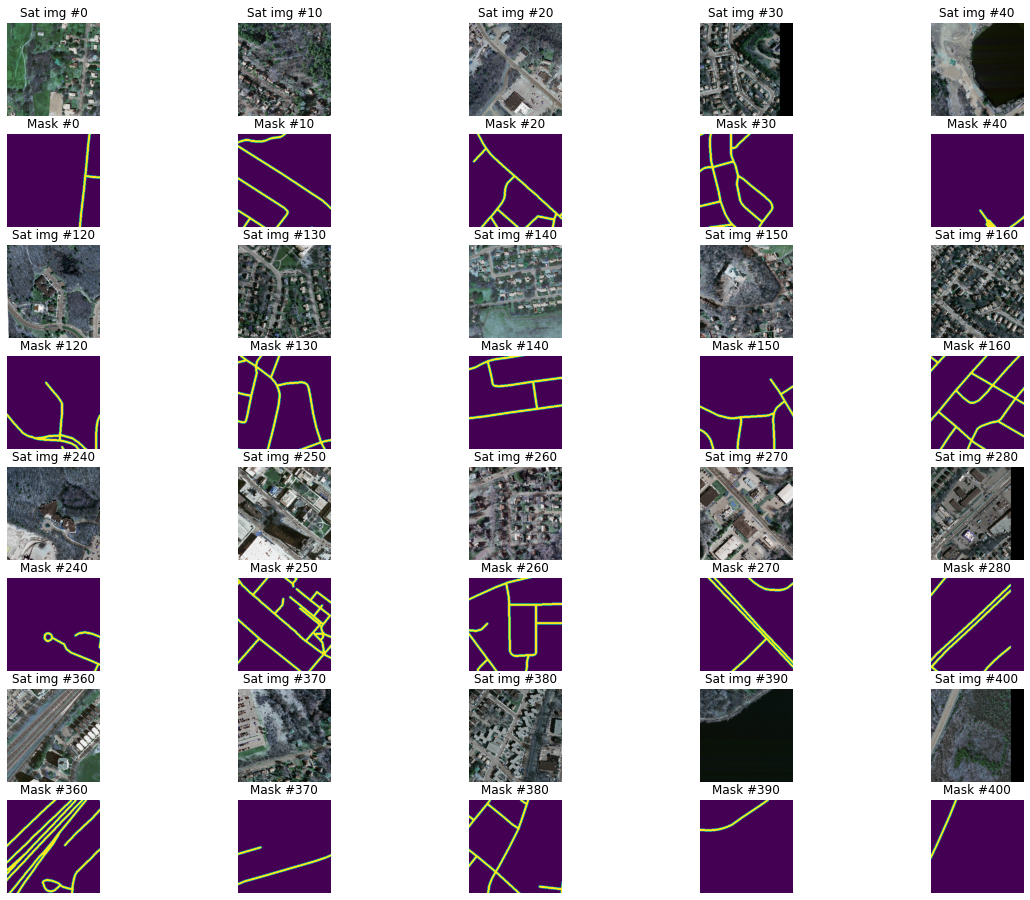

In [13]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()
masks = np.expand_dims(masks, -1)

# Improving boundary detection : 

* The main weakness of our model is that it fails at detecting building boundaries with great precision. It has a propensity to give us soft edges, instead of sharp and well defined ones. This is especially an issue in densely populated areas where buildings are close:

* We tried to find a way to improve the accuracy of classi- fication on boundaries. The idea is to weight the inner and outer borders of the buildings. Looking at the formula of the Dice coefficient, by weighting negatively the pixel on the outer border of the building instead of just zero, we will penalize the loss strongly if the model outputs a non-zero probability on these pixels. On the contrary, we want the model to be rewarded if it classifies accurately the inner border of a building, so we weight positively the inner border (if the model outputs a high probability for this pixel, the loss will notably decrease). That last modification allows us to roughly compensate the pixels weighted negatively in the denominator.

* We were unable however to quantify that improvement. While it was clear that the output was more accurate than before in terms of boundary definition, this was not reflected on the value of the dice coefficient, which actually turned out to be slightly lower. Testing the improved model on the test

In [15]:
#accuracy Metric
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
    return iou

In [16]:
#loss function
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [17]:
print(masks.shape)
print(images.shape)

(449, 256, 256, 1)
(449, 256, 256, 3)


In [18]:
model = load_model("../Models/Road_Detection_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [20]:
model.evaluate(images,masks)

449/449 [==============================] - 12s 27ms/step


[-0.48445220567070296, 6.884310245513916]

In [22]:
predictions = model.predict(images, verbose=1)

449/449 [==============================] - 7s 16ms/step


In [23]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

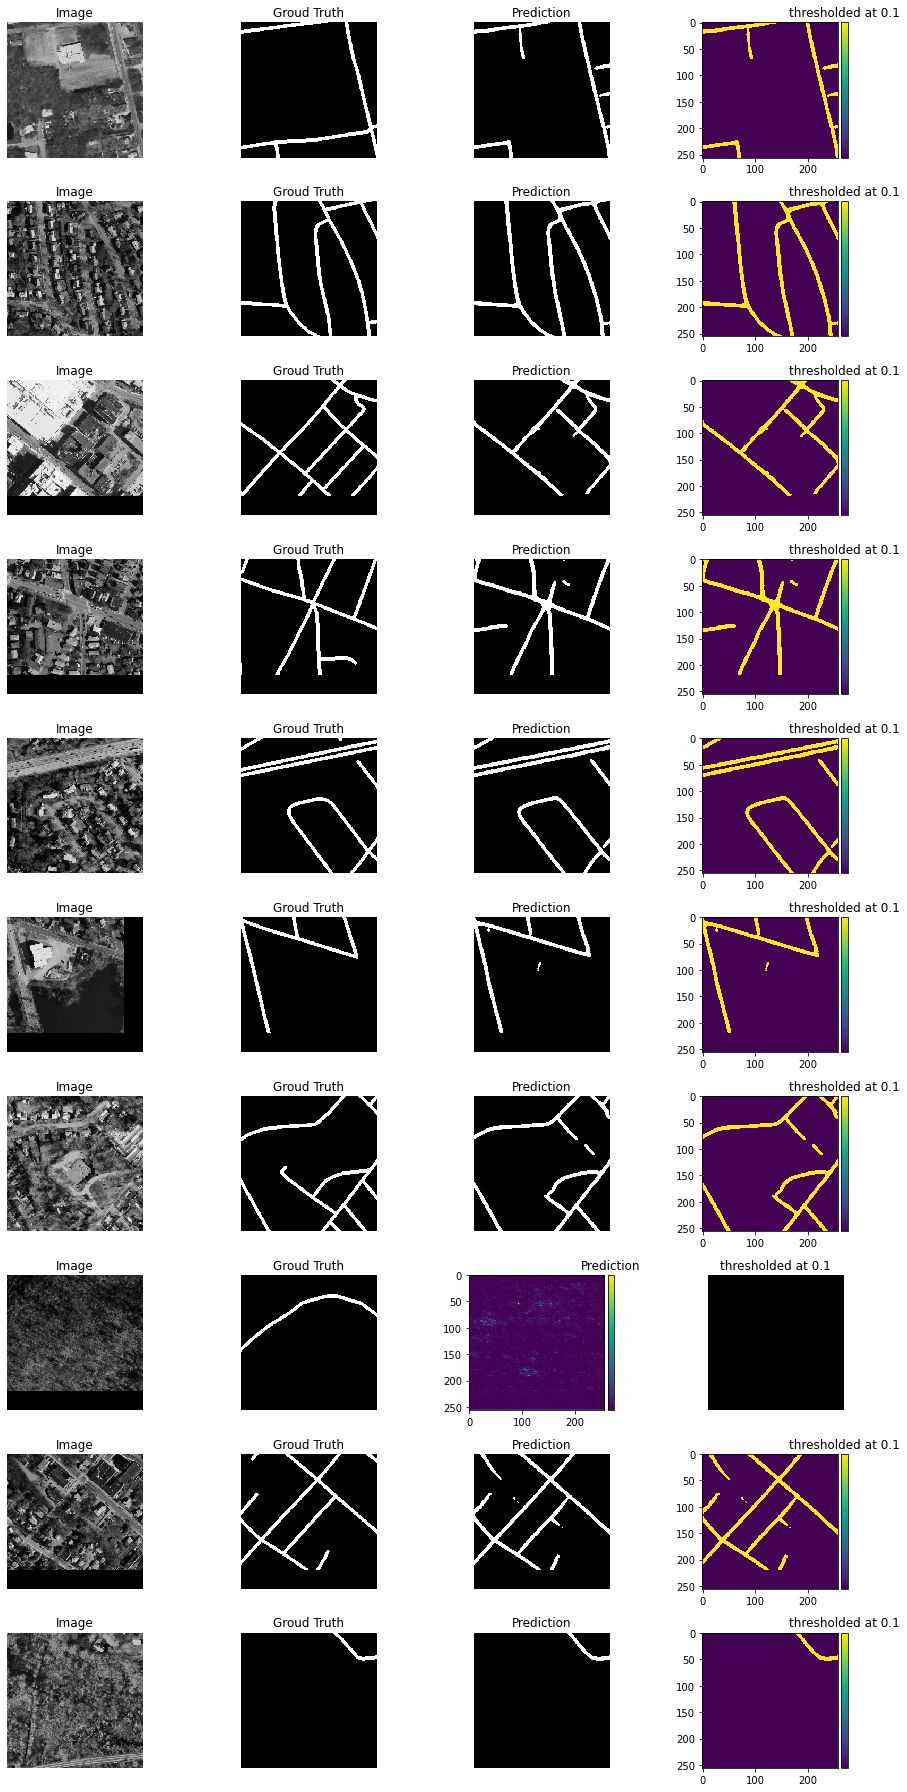

In [27]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()


# Conclusion : 

In this project, we examined an end-to-end approach for semantic segmentation of satellite images for building de- tection using few data, and with a relatively low resolution. We implemented a CNN based on the U-net architecture developed by Ronneberger et al. in [7] and used the MapBox API in OpenStreetMap to collect the datasets of interest. We used the high-level python API Keras to implement our model and facilitate data augmentation in order to improve its robustness. Our proposed approach achieved a reasonable accuracy, though slightly lower than state-of-the-art results published in the literature using other CNN architectures, and without post-processing. We then proposed a way to tackle the imprecise semantic segmentation of boundaries outputted by our model. Building upon this work and with the aim of preserving semantic boundaries, we plan to extend our network with further geometric cues and a uncertainty weighted multi- task loss, inspired by [3].
